### 1. Load Train / Test / Validation Data Files

In [1]:
import numpy as np

In [2]:
train_features_path =  "../feature/BENGALI-RESNET-feature/train_features_triplet_loss.npy"
train_names_path = "../feature/BENGALI-RESNET-feature/train_names.npy"
train_labels_path = "../feature/BENGALI-RESNET-feature/train_labels.npy"

test_features_path = "../feature/BENGALI-RESNET-feature/test_features_triplet_loss.npy"
test_names_path = "../feature/BENGALI-RESNET-feature/test_names.npy"
test_labels_path = "../feature/BENGALI-RESNET-feature/test_labels.npy"

validation_features_path = "../feature/BENGALI-RESNET-feature/validation_features_triplet_loss.npy"
validation_names_path = "../feature/BENGALI-RESNET-feature/validation_names.npy"
validation_labels_path = "../feature/BENGALI-RESNET-feature/validation_labels.npy"

gallery_feature_path = "../feature/BENGALI-RESNET-feature/gallery_features_triplet_loss.npy"
gallery_name_path = "../feature/BENGALI-RESNET-feature/gallery_names.npy"

train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

gallery_features = np.load(gallery_feature_path)
gallery_names = np.load(gallery_name_path)

In [3]:
print(train_features.shape)
print(train_labels.shape)
print(train_names.shape)
print(test_features.shape)
print(test_labels.shape)
print(test_names.shape)
print(validation_features.shape)
print(validation_labels.shape)
print(validation_names.shape)
print(gallery_features.shape)
print(gallery_names.shape)

(3200, 2048)
(3200,)
(3200,)
(1100, 2048)
(1100,)
(1100,)
(1100, 2048)
(1100,)
(1100,)
(100, 2048)
(100,)


In [4]:
def find_difference_vector(vector_features, vector_labels, vector_names, gallery_features, gallery_names):
    difference_vectors = []
    difference_names = []
    difference_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_difference_name = gallery_name
        curr_difference_feature = []
        curr_difference_label = []
        curr_difference = []
        
        for feature, name, label in zip(vector_features, vector_names, vector_labels):
            # print(f"Gallery Name: {gallery_name}, Name: {name}")
            if gallery_name == name:
                curr_difference_feature.append(feature)
                curr_difference_label.append(label)
        
        if curr_difference_feature:  # Check if the list is not empty
            # Assuming curr_difference_feature, curr_difference_label, and gallery_feature are numpy arrays
            curr_difference_feature = np.array(curr_difference_feature)
            curr_difference_label = np.array(curr_difference_label)
            curr_difference = curr_difference_feature - gallery_feature

            difference_vectors.append(curr_difference)
            difference_names.append(curr_difference_name)
            difference_labels.append(curr_difference_label)
            
    return difference_vectors, difference_names, difference_labels

In [5]:
test_difference_vectors, test_difference_names, test_difference_labels = find_difference_vector(test_features, test_labels, test_names, gallery_features, gallery_names)
train_difference_vectors, train_difference_names, train_difference_labels = find_difference_vector(train_features, train_labels, train_names, gallery_features, gallery_names)
validation_difference_vectors, validation_difference_names, validation_difference_labels = find_difference_vector(validation_features, validation_labels, validation_names, gallery_features, gallery_names)

### 2. Train on ML

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [7]:
# For Train Set
train_difference_vectors_flat = [item for sublist in train_difference_vectors for item in sublist]
train_difference_array = np.array(train_difference_vectors_flat).reshape(len(train_difference_vectors_flat), -1)

# For test set
test_difference_vectors_flat = [item for sublist in test_difference_vectors for item in sublist]
test_difference_array = np.array(test_difference_vectors_flat).reshape(len(test_difference_vectors_flat), -1)

# For validation set
validation_difference_vectors_flat = [item for sublist in validation_difference_vectors for item in sublist]
validation_difference_array = np.array(validation_difference_vectors_flat).reshape(len(validation_difference_vectors_flat), -1)

In [8]:
print(train_difference_array.shape)
print(train_labels.shape)
print(test_difference_array.shape)
print(test_labels.shape)
print(validation_difference_array.shape)
print(validation_labels.shape)

(3200, 2048)
(3200,)
(1100, 2048)
(1100,)
(1100, 2048)
(1100,)


In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators) based on your needs
model.fit(train_difference_array, train_labels)

RandomForestClassifier(random_state=42)

### 3. Hyperparameter Tuning

In [10]:
parameter = model.get_params()
for key, value in parameter.items():
    print(f"{key}: {value}")

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


In [11]:
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(validation_difference_array, validation_labels)
best_params = grid_search.best_params_

In [12]:
print(best_params)

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}


### 4. Test

In [13]:
best_model = RandomForestClassifier(**best_params)
best_model.fit(train_difference_array , train_labels)
test_pred = best_model.predict(test_difference_array)
accuracy = accuracy_score(test_labels, test_pred)

In [14]:
print(accuracy)

0.8827272727272727


### 5. ROC Curve

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

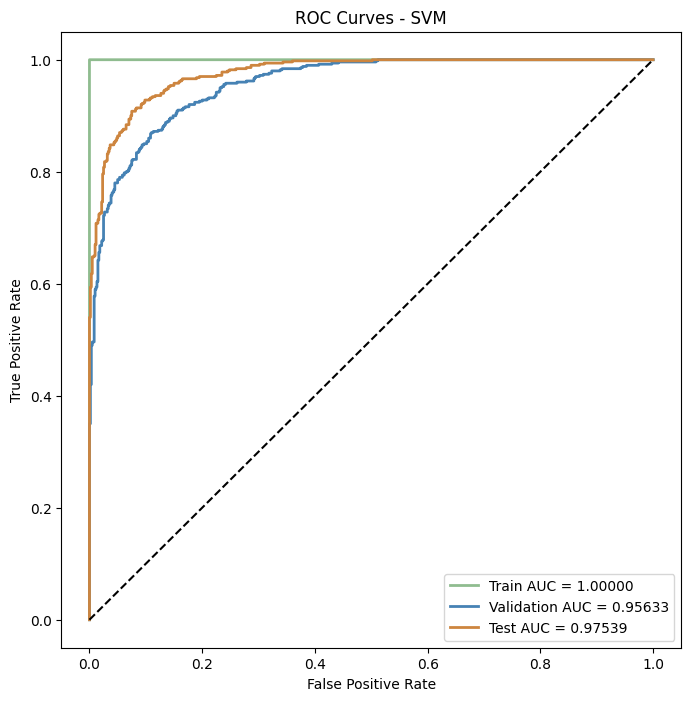

In [16]:
# Predict decision values for each class
y_train_score = best_model.predict_proba(train_difference_array)[:, 1]
y_test_score = best_model.predict_proba(test_difference_array)[:, 1]
y_val_score = best_model.predict_proba(validation_difference_array)[:, 1]

# Compute ROC curve and AUC for each set
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, y_train_score, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, y_test_score, drop_intermediate=False)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_val, tpr_val, thresholds_val = roc_curve(validation_labels, y_val_score, drop_intermediate=False)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve
plt.figure(figsize=(8, 8))

plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
plt.plot(fpr_val, tpr_val, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_val:.5f}')
plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - SVM')
plt.legend()
plt.show()

In [17]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [18]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_val, tpr_val, fpr) for fpr in target_fprs]

In [19]:
print(tpr_test)

[0.    0.002 0.004 ... 1.    1.    1.   ]


In [20]:
print(fpr_test)

[0.         0.         0.         ... 0.995      0.99833333 1.        ]


In [21]:
print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_val}')

print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')

Train
TPR at FPR 0.100: 1.000
TPR at FPR 0.010: 1.000
TPR at FPR 0.001: 1.000
             AUC: 1.0
Validation
TPR at FPR 0.100: 0.850
TPR at FPR 0.010: 0.590
TPR at FPR 0.001: 0.350
             AUC: 0.9563266666666667
Test
TPR at FPR 0.100: 0.928
TPR at FPR 0.010: 0.670
TPR at FPR 0.001: 0.540
             AUC: 0.9753866666666666
